# Cart Pendulum balancing using Policy Gradients
This example shows how to apply policy gradients in order to stabilze an inverted pendulum on a cart.

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import numpy as np

checkpoint_file = "./weights/policy_gradient_cart_pendulum_balance.ckpt"

In [3]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

## Defining environment functions
We start by definin some of the functions for the environment.
- The reward is 1 when the agent is within $0.1$ rad $\approx 5.7 $ degrees oft the upright position
- The actions available to the agent are $\pm20, \pm 10, \pm 1 $ and $0$ Newtons of force on the cart
- The terminal conditions are when the cart is $\pm 2$m from the center or the pendulum is more than $0.5$ rad $\approx 29$ degrees from the vertical position.
- The state avalable to the agent is $x, \theta, \dot{x}, \dot{\theta}, \sin(\theta), \cos(\theta)$ where $x$ is the position of the cart and $\theta$ is the angle of the pendulum

In [4]:
# Define reward function
env.reward = lambda : -10 if env.terminal() else (1 if np.cos(env.x[1]) > np.cos(0.1) else 0)

# Define legal actions 
env.actions = lambda : np.array([-20, -10, -1, 0, 1, 10, 20])

# Define terminal state
env.terminal = lambda : np.abs(env.x[0]) > 2 or np.abs(env.x[1]) > 0.5

# Define state variabels
r = lambda theta : ((theta/np.pi - 1) % 2)*np.pi - np.pi
env.state = lambda : np.array([env.x[0], r(env.x[1]), env.x[2], env.x[3]])

## Creating the policy based agent
we first create a discounting function which takes in the reward over time, and returns a the discounted sequence of rewards given the discounting factor $\gamma$. The total discounted reward at time $t$ can be written as: 
$$G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \dots $$ 
Recursively this can be written as:
$$ G_t = R_{t} + \gamma G_{t+1} $$

In [5]:
def discount_rewards(rewards, gamma):
    discounted_reward = np.zeros(rewards.shape)
    for t in reversed(range(0, rewards.size)):
        discounted_reward[t] = discounted_reward[(t + 1)%rewards.shape[0]]*gamma + rewards[t]
    return discounted_reward

The function approximator used is a neural network, here we use a ntwork with one hidden layer, where the input is the state, and the output is the probability distribution for selecting any of the available actions. The trainig consists of simulating the environment by following some policy until we reach the terminal conditions. We then calculate the gradients of the for each time step and multiply the gradients with thediscounted reward. we then nudge the policy network in this direction in order to promote good behaveour and punish bad behaveoure

In [6]:
class agent():
    def __init__(self, lr, s_size, a_size, h_shape):
        # Dropout probability
        #self.keep_prob = tf.placeholder(tf.float32)
        self.trainig = False
        
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        self.hidden = slim.stack(self.state_in, slim.fully_connected, h_shape, biases_initializer=None, activation_fn=tf.nn.relu)
        self.dropout = slim.dropout(self.hidden, is_training=self.trainig)
        self.output = slim.fully_connected(self.dropout,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [ ]:
tf.reset_default_graph() # Clear the Tensorflow graph.

myAgent = agent(lr = 1e-2, s_size=len(env.state()) ,a_size = len(env.actions()), h_shape=[8, 16])
saver = tf.train.Saver() # Create a tensorflow saver

# Set number of episodes, max numer of steps and how often we train the nework
total_episodes = 5000
max_steps = 1000
update_frequency = 5
save_frequency = 100
gamma = 0.99

best_score = 0

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    #saver.restore(sess, checkpoint_file)
    i = 1
    total_reward = []
    total_lenght = []
        
    update_history = np.zeros((0,4))
    
    while i <= total_episodes:
        theta =  (2*np.random.random() - 1)*0.4*i/total_episodes
        state = env.init([0,theta,0,0])
        running_reward = 0
        ep_history = []
        for j in range(max_steps):
            # No dropout during sampling
            myAgent.training = False
            
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[state]})
            action = np.random.choice(env.actions(),p=a_dist[0])
            action_idx = np.argmax(env.actions() == action)

            next_state = env.step(env.actions()[action_idx])
            reward = env.reward()
            ep_history.append([state,action_idx,reward,next_state])
            state = next_state
            running_reward += reward
            if env.terminal() == True or (j + 1) == max_steps:
                #Add episode to update history for use during learning
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2], gamma)
                update_history = np.append(update_history, ep_history, axis = 0)
                
                # Update the policy network on the episode batch
                if i % update_frequency == 0:
                    # Enable dropout
                    myAgent.training = True
                    
                    # Compute and subtract baseline from reward in order to lower variance
                    baseline = np.mean(update_history[:, 2])
                    update_history[:, 2] = update_history[:, 2] - baseline
                    
                    # Find gradients of traing batch
                    feed_dict={myAgent.reward_holder:ep_history[:,2],
                               myAgent.action_holder:ep_history[:,1],
                               myAgent.state_in:np.vstack(ep_history[:,0])}
                    grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                    
                    # Train network using calculated gradients
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, grads))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    
                    # Reset update history for next traing batch
                    update_history = np.zeros((0,4))
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
        # Print trainig progress and save network
        if i % save_frequency == 0:
            mean_reward = np.mean(total_reward[-save_frequency:])
            print("Num episodes: {}, Mean reward: {}".format(i, mean_reward))
            if mean_reward > best_score:
                saver.save(sess, checkpoint_file)
                best_score = mean_reward
        i += 1

## Show training progress

In [ ]:
from ipywidgets import widgets

def plot_moving_average(window_size):
    interval = total_reward
    window= np.ones(int(window_size))/float(window_size)
    data = np.convolve(interval, window, 'valid')
    plt.plot(data)
    plt.show()

slider = widgets.interact(plot_moving_average, window_size=(1, 1000, 1))

## Simulating results
The code below will render the cart pnedulum, you may get the error that ffmpg is not installed, for anaconda users this can be done by 
```bash
conda install -c conda-forge ffmpeg
```

In [10]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 1000
X = np.zeros((len(env.x), n_steps))
with tf.Session() as sess:
    myAgent.training = False
    saver.restore(sess, checkpoint_file)
    theta = (2*np.random.random() - 1)*0.4
    state = env.init([0, theta, 0, 0])
    for step in range(n_steps):
        X[:, step] = env.x
        a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[state]})
        state = env.step(env.actions()[np.argmax(a_dist)])

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[0,i] - 0.2, -0.1]), 
                     line.set_data([X[0,i], X[0,i] + np.sin(X[1, i])],[0, np.cos(X[1, i])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)
HTML(anim.to_html5_video())

INFO:tensorflow:Restoring parameters from ./weights/policy_gradient_cart_pendulum_balance.ckpt


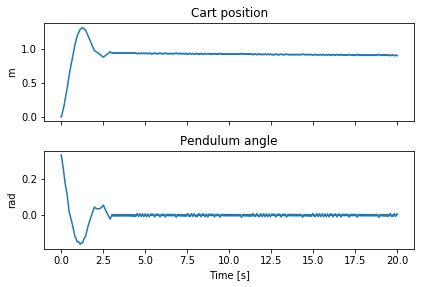

In [14]:
# Plot trajectory
#%matplotlib inline
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(2, sharex=True)
for i in range(len(axarr)):
    axarr[i].plot(t, X.T[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()